In [5]:
import numpy as np
from numpy import ma
from pyproj import Geod
from metpy.io.nexrad import Level2File
from metpy.plots import ctables
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os, tarfile, wget, re
import boto3
from botocore.handlers import disable_signing
import matplotlib.pyplot as plt
%matplotlib inline

## NEXRAD Level II Data

* Using NEXRAD Level II data directly from hosting on AWS S3: [NEXRAD Level II Data](https://s3.amazonaws.com/noaa-nexrad-level2/index.html)
* Using [Marshall-Palmer equation](https://en.wikipedia.org/wiki/DBZ_(meteorology)) to turn reflectivity data into precipitation rate (in mm/hr) which will need to be converted into the actual precipitation later

In [24]:
s3_client = boto3.client('s3')
resource = boto3.resource('s3')
# Disable signing for anonymous requests to public bucket
resource.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)

nexrad_bucket = resource.Bucket('noaa-nexrad-level2')
paginator = s3_client.get_paginator('list_objects')
klot_95 = list()
for result in s3_client.list_objects(Bucket='noaa-nexrad-level2', Prefix='1995')['Contents']:
    #print(result)
    #print(type(result['Key']))
#     if (result['Key'].find('KLOT') != -1) and (result['Key'].endswith('.gz')):
#     #if (result['Key'].endswith('.gz')):
#         klot_95.append(result['Key'])
# print(klot_95[:5])

SyntaxError: unexpected EOF while parsing (<ipython-input-24-3fb9f32b49a4>, line 15)

In [14]:
s3_client = boto3.client('s3')
resource = boto3.resource('s3')
# Disable signing for anonymous requests to public bucket
resource.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)

nexrad_bucket = resource.Bucket('noaa-nexrad-level2')
local_filepath = 'nexrad_data/KLOT20110723_074851_V03.gz'
nexrad_bucket.download_file('2011/07/23/KLOT/KLOT20110723_074851_V03.gz', local_filepath)

f = Level2File(local_filepath)
f.sweeps[0][0]

(Msg31DataHdr(stid=b'KLOT', time_ms=28131423, date=15179, az_num=1, az_angle=59.2108154296875, compression=0, rad_length=2004, az_spacing=1, rad_status=5, el_num=1, sector_num=1, el_angle=0.4833984375, spot_blanking=None, az_index_mode=0.25, num_data_blks=4, vol_const_ptr=68, el_const_ptr=112, rad_const_ptr=124),
 VolConsts(type=b'R', name=b'VOL', size=44, major=1, minor=0, lat=41.60444259643555, lon=-88.08416748046875, site_amsl=202, feedhorn_agl=25, calib_dbz=-45.297325134277344, txpower_h=670.0525512695312, txpower_v=0.0, sys_zdr=0.0, phidp0=0.0, vcp=212, processing_status=None),
 ElConsts(type=b'R', name=b'ELV', size=12, atmos_atten=-0.012, calib_dbz0=-44.4375),
 RadConstsV1(type=b'R', name=b'RAD', size=20, unamb_range=466.0, noise_h=-80.24567413330078, noise_v=0.0, nyq_vel=8.34),
 {b'REF': (DataBlockHdr(type=b'D', name=b'REF', reserved=0, num_gates=1832, first_gate=2.125, gate_width=0.25, tover=5.0, snr_thresh=1.6, recombined=None, data_size='B', scale=2.0, offset=66.0),
   array(

In [4]:
local_filepath = 'nexrad_data/KLOT20110723_074851_V03.gz'
f = Level2File(local_filepath)
# Pull data out of the file
sweep = 0

# First item in ray is header, which has azimuth angle
az = np.array([ray[0].az_angle for ray in f.sweeps[sweep]])

# 5th item is a dict mapping a var name (byte string) to a tuple
# of (header, data array)
ref_hdr = f.sweeps[sweep][0][4][b'REF'][0]
ref_range = np.arange(ref_hdr.num_gates) * ref_hdr.gate_width + ref_hdr.first_gate
ref = np.array([ray[4][b'REF'][1] for ray in f.sweeps[sweep]])

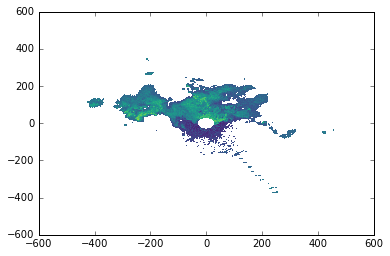

In [5]:
# fig, axes = plt.subplots(1, 2, figsize=(15, 8))
# for var_data, var_range, ax in zip((ref, rho), (ref_range, rho_range), axes):
# Turn into an array, then mask
data = ma.array(ref)
data[np.isnan(data)] = ma.masked

# Convert az,range to x,y
xlocs = ref_range * np.sin(np.deg2rad(az[:, np.newaxis]))
ylocs = ref_range * np.cos(np.deg2rad(az[:, np.newaxis]))

# Plot the data
cmap = ctables.registry.get_colortable('viridis')
plt.pcolormesh(xlocs, ylocs, data, cmap=cmap)
#plt.set_aspect('equal', 'datalim')

plt.show()

In [54]:
def extract_data(filepath):
    f = Level2File(filepath)
    # Pull data out of the file
    sweep = 0

    # First item in ray is header, which has azimuth angle
    az = np.array([ray[0].az_angle for ray in f.sweeps[sweep]])

    # 5th item is a dict mapping a var name (byte string) to a tuple
    # of (header, data array)
    ref_hdr = f.sweeps[sweep][0][4][b'REF'][0]
    ref_range = np.arange(ref_hdr.num_gates) * ref_hdr.gate_width + ref_hdr.first_gate
    ref = np.array([ray[4][b'REF'][1] for ray in f.sweeps[sweep]])
    
    data_hdr = f.sweeps[sweep][0][1]
    
    data = ma.array(ref)
    data[data==0] = ma.masked

    # Data from MetPy needs to be converted to latitude and longitude coordinates
    g = Geod(ellps='clrk66')
    center_lat = np.ones([len(az),len(ref_range)])*data_hdr.lat
    center_lon = np.ones([len(az),len(ref_range)])*data_hdr.lon

    az2D = np.ones_like(center_lat)*az[:,None]
    rng2D = np.ones_like(center_lat)*np.transpose(ref_range[:,None])*1000
    lon,lat,back = g.fwd(center_lon,center_lat,az2D,rng2D)
    
    return lon, lat, data

def unstack_process(lon, lat, data):
    lat_df = pd.DataFrame(lat)
    lon_df = pd.DataFrame(lon)
    data_df = pd.DataFrame(data)
    
    lon_stack = lon_df.stack().reset_index()
    lon_stack = lon_stack.rename(columns={'level_0': 'x', 'level_1': 'y', 0: 'lon'})
    lat_stack = lat_df.stack().reset_index()
    lat_stack = lat_stack.rename(columns={'level_0': 'x', 'level_1': 'y', 0: 'lat'})
    coord_merge = pd.merge(lat_stack, lon_stack, on=['x', 'y']).reset_index()
    # Reducing to bounding box through selection rather than geospatial operation
    coord_merge = coord_merge.loc[(coord_merge['lat'] <= 42.0231311) &
                                  (coord_merge['lat'] >= 41.644335) &
                                  (coord_merge['lon'] <= -87.524044) &
                                  (coord_merge['lon'] >= -87.940267)]
    data_stack = data_df.stack().reset_index()
    data_stack = data_stack.rename(columns={'level_0': 'x', 'level_1': 'y', 0: 'precip'})
    merged_data = pd.merge(coord_merge, data_stack, on=['x', 'y'], how='left')[['lat','lon','precip']]
    nexrad_df = merged_data.dropna().copy()
    # Convert precip in dBZ into mm/hr using Marshall-Palmer https://en.wikipedia.org/wiki/DBZ_(meteorology)
    nexrad_df.loc['precip'] = pow(pow(10, nexrad_df['precip']/10)/200, 0.625)
    return nexrad_df.dropna()
    
def spatial_join(nexrad_df, gpd_file, group_col, file_time):
    geo_df = gpd.read_file(gpd_file)
    crs = {'init':'epsg:4326'}
    geo_df.crs = crs
    geometry = nexrad_df.apply(lambda z: Point(z['lon'], z['lat']), axis=1).dropna()
    #geometry = [Point(xy) for xy in zip(nexrad_df.lon, nexrad_df.lat)]
    nexrad_geo = gpd.GeoDataFrame(nexrad_df, crs=crs, geometry=geometry)
    nexrad_geo.crs = geo_df.crs
    merged_nexrad = gpd.tools.sjoin(nexrad_geo, geo_df, how='right', op='within') #.reset_index()
    nexrad_grouped = merged_nexrad.groupby([group_col])['precip'].mean().reset_index()
    nexrad_grouped[group_col] = nexrad_grouped[group_col].astype(int)
    nexrad_grouped.fillna(value=0, inplace=True)
    nexrad_grouped.sort_values(by=group_col, inplace=True)
    nexrad_grouped.to_csv('data/nexrad_processed/{}_{}.csv'.format(group_col, file_time), index=False)

In [57]:
file_time = re.search(r'\d{8}_\d{6}',local_filepath).group()
lon, lat, data = extract_data(local_filepath)
print(data.shape)
nexrad_df = unstack_process(lon, lat, data)
spatial_join(nexrad_df, 'data/chicago_wards.geojson', 'ward', file_time)

(720, 1832)
    index  x   y        lat        lon
48     48  0  48  41.669450 -87.938465
49     49  0  49  41.670599 -87.935883
50     50  0  50  41.671748 -87.933302
51     51  0  51  41.672897 -87.930720
52     52  0  52  41.674046 -87.928139


In [52]:
geo_df.info(verbose=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
geometry    50 non-null object
ward        50 non-null object
dtypes: object(2)
memory usage: 880.0+ bytes


In [53]:
nexrad_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 18083 entries, 0 to precip
Data columns (total 4 columns):
lat         18082 non-null float64
lon         18082 non-null float64
precip      18082 non-null float64
geometry    18083 non-null object
dtypes: float64(3), object(1)
memory usage: 706.4+ KB
